In [1]:
from utils import *

Info: Found credentials at: /Users/lelias/Library/CloudStorage/Box-Box/dvutils-creds-lelias.json
Admin ArcGIS client created


## Load PCA Layers definitions from YAML

In [2]:
## Load data dictionary
pca_data = load_dict_from_yaml()
[print(f"{k}: {v['use']}") for k,v in pca_data.items()]

pca: pca_geographies
pca_ammend: pca_geographies
natural_land: pca_type
working_land: pca_type
urban_greening: pca_type
recreation: pca_type
climate_adaptation: pca_type
ugb: ugb


[None, None, None, None, None, None, None, None]

In [3]:
## Create subset dictionaries
## PCA Geographies. Select either 'pca' or 'pca_ammend' for the PCA geographies

## Option A: PCA
# pca_geo = pca_data['pca']

## Option B: PCA DRAFT Amendement
pca_geo = pca_data['pca_ammend']


# PCA Types
pca_types = create_subset_dict(pca_data, 'use', 'pca_type')
# UGB
ugb = pca_data['ugb']

## Load PCA Layers from Feather Files

Opening file from _data/feather_files/pca_shp_integration.feather



<Axes: >

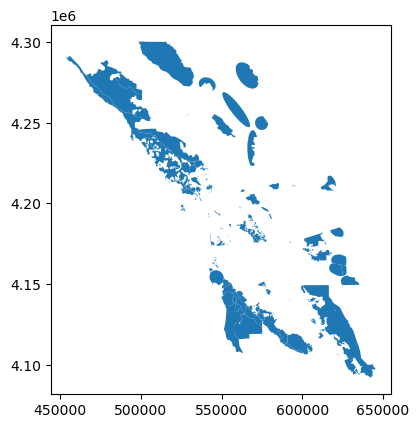

In [4]:
## Load PCA Geographies from Feather file
pca_geo['data_load'] = open_feather(pca_geo['filename'])
## Process PCA Geographies
process_data_load(pca_geo)

pca_geo['data'].plot()

Loading data for natural_land
Opening file from _data/feather_files/natural_land.feather

Data loaded successfully

Loading data for working_land
Opening file from _data/feather_files/working_land.feather

Data loaded successfully

Loading data for urban_greening
Opening file from _data/feather_files/urban_greening.feather

Data loaded successfully

Loading data for recreation
Opening file from _data/feather_files/recreation.feather

Data loaded successfully

Loading data for climate_adaptation
Opening file from _data/feather_files/climate_adaptation.feather

Data loaded successfully



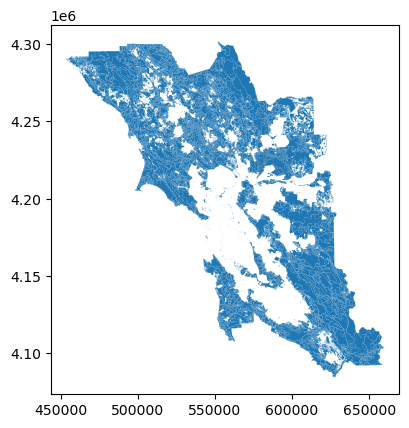

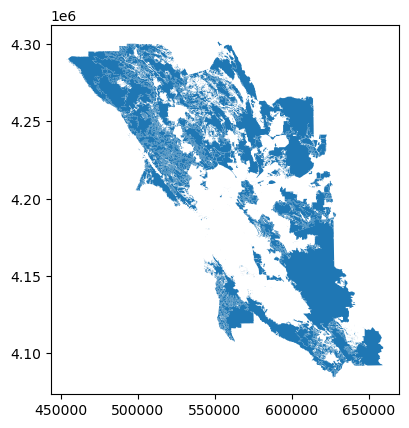

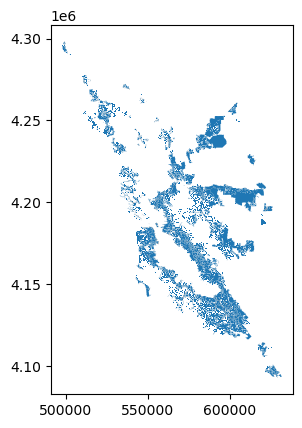

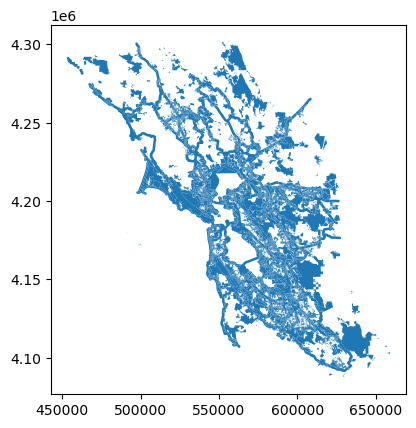

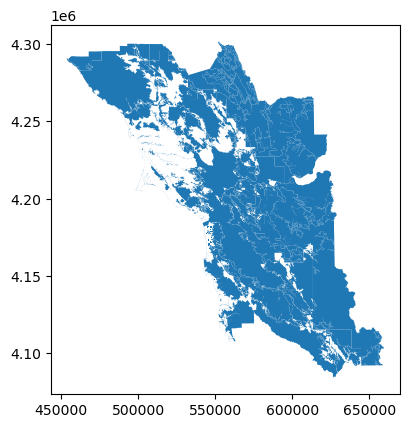

In [5]:
## Load PCA types
for i in pca_types.keys():
    try:
        print(f"Loading data for {i}")
        ## Load PCA type from Feather file
        pca_types[i]['data_load'] = open_feather(pca_types[i]['filename'])
        pca_types[i]['data_load'].plot()
        print("Data loaded successfully\n")
    except Exception as e:
        print(f"Failed to load data for {i}!\n")

Opening file from _data/feather_files/ugb.feather



<Axes: >

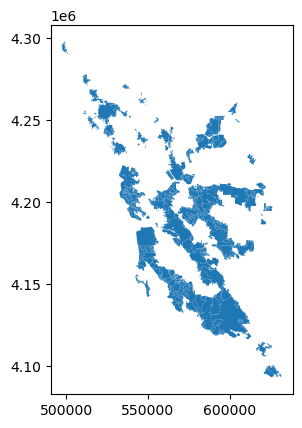

In [6]:
## Load UGB
## Load UGB from Feather file
ugb['data_load'] = open_feather(ugb['filename'])
## Process UGB
process_data_load(ugb)

ugb['data'].plot()

## Flag #1 PCA Geographies to PCA Types

### Create Footprints for PCA Types

In [7]:
create_footprints_for_dict(pca_types, 'flag')

Found Footprint for dataset: natural_land. Loading from file
Opening file from _data/feather_files/natural_land_footprint.feather

Found Footprint for dataset: working_land. Loading from file
Opening file from _data/feather_files/working_land_footprint.feather

Found Footprint for dataset: urban_greening. Loading from file
Opening file from _data/feather_files/urban_greening_footprint.feather

Found Footprint for dataset: recreation. Loading from file
Opening file from _data/feather_files/recreation_footprint.feather

Found Footprint for dataset: climate_adaptation. Loading from file
Opening file from _data/feather_files/climate_adaptation_footprint.feather



### Fix Topology

In [8]:
from shapely.geometry import LineString
pca_types['recreation']['footprint'] = pca_types['recreation']['footprint'][pca_types['recreation']['footprint'].geom_type != 'LineString'].reset_index(drop=True)

In [9]:
# ## Manually export footprints to Feather files
# feather_dir = "_data/feather_files"

# for k, v in pca_types.items():
#     print(f"Exporting Footprint to Feather file")
#     # Set Data Directory
#     feather_file = os.path.join(feather_dir, f"{v['filename']}_footprint.feather")
#     v["footprint"].to_feather(feather_file)

### Assign PCA Type Footprints to PCA Geographies

In [10]:
assign_footprints_from_dictionary(pca_geo, pca_types, 'flag')

Dataset natural_land: Starting Assignment of Footprint
Creating Base GeoDataframe to Input GeoDataframe correspondence
Running Overlay process
Running Overlay process successful
Processing final fields: ['gdf_id', '1nl']
took 1.1471 seconds
Creating area_sq_m
Dataset natural_land: Assignment of Footprint complete

Dataset working_land: Starting Assignment of Footprint
Creating Base GeoDataframe to Input GeoDataframe correspondence
Running Overlay process
Running Overlay process successful
Processing final fields: ['gdf_id', '1wl']
took 2.2721 seconds
Dataset working_land: Assignment of Footprint complete

Dataset urban_greening: Starting Assignment of Footprint
Creating Base GeoDataframe to Input GeoDataframe correspondence
Running Overlay process
Running Overlay process successful
Processing final fields: ['gdf_id', '1ug']
took 11.0757 seconds
Dataset urban_greening: Assignment of Footprint complete

Dataset recreation: Starting Assignment of Footprint
Creating Base GeoDataframe to In

In [11]:
for pca_type, type_att in pca_types.items():
    try:
        print('Displaying Assignment of Footprint for PCA Type:', pca_type)
        display(type_att['assignment'].sample(3))
    except:
        print(f'Display of Assignment of Footprint for PCA Type {pca_type} failed!')

Displaying Assignment of Footprint for PCA Type: natural_land


,joinkey,source,fipco,name,lead,amend_stat,amend_lead,typenl,typeal,typeug,...,Version,Edit_Notes,acres,INSIDE_X,INSIDE_Y,gdf_id,area_sq_m,1nl,1nl_intersect_sq_m,1nl_share_pct
44,MR5,MR5_Draft.shp,06041,Marin City Ridge,"National Park Service, Golden Gate National Re...",Draft,MTC,0,0,0,...,0,0,66.590929,-122.51909,37.872332,45,2.694839e+05,NaN,NaN,NaN
65,SM16,PCA_Midpen_2024Refresh_SanMateoCounty.shp,06081,South Skyline,Midpeninsula Regional Open Space District,nan,Local Lead,1,0,0,...,0,0,11721.921779,0.00000,0.000000,66,4.743693e+07,1.0,4.722218e+07,0.995473
59,SM1,PCA_Midpen_2024Refresh_SanMateoCounty.shp,06081,Montara Mountain Complex,Peninsula Open Space Trust,nan,Local Lead,1,0,0,...,0,0,14989.552979,0.00000,0.000000,60,6.066057e+07,1.0,4.689179e+07,0.773019


Displaying Assignment of Footprint for PCA Type: working_land


,joinkey,source,fipco,name,lead,amend_stat,amend_lead,typenl,typeal,typeug,...,Version,Edit_Notes,acres,INSIDE_X,INSIDE_Y,gdf_id,area_sq_m,1wl,1wl_intersect_sq_m,1wl_share_pct
35,MR11,MR11_Draft.shp,06041,Tiburon Ridge Lands,Marin County Parks and Open Space Department,Draft,MTC,0,0,0,...,0,0,536.324857,-122.460248,37.891182,36,2.170430e+06,1.0,34202.215483,0.015758
89,SC49,SC49_Draft.shp,06085,Coyote Valley - North,Santa Clara Valley Open Space Authority,Draft,MTC,0,0,1,...,0,0,1638.606573,-121.743274,37.201817,90,6.631206e+06,1.0,2478.063610,0.000374
44,MR5,MR5_Draft.shp,06041,Marin City Ridge,"National Park Service, Golden Gate National Re...",Draft,MTC,0,0,0,...,0,0,66.590929,-122.519090,37.872332,45,2.694839e+05,NaN,NaN,NaN


Displaying Assignment of Footprint for PCA Type: urban_greening


,joinkey,source,fipco,name,lead,amend_stat,amend_lead,typenl,typeal,typeug,...,Version,Edit_Notes,acres,INSIDE_X,INSIDE_Y,gdf_id,area_sq_m,1ug,1ug_intersect_sq_m,1ug_share_pct
16,AL5,AL5_Draft.shp,06001,East Bay Greenway,City of Oakland,Draft,MTC,0,0,1,...,0,0,453.695561,-122.194555,37.751983,17,1.836041e+06,1.0,1.813231e+06,0.987577
65,SM16,PCA_Midpen_2024Refresh_SanMateoCounty.shp,06081,South Skyline,Midpeninsula Regional Open Space District,nan,Local Lead,1,0,0,...,0,0,11721.921779,0.000000,0.000000,66,4.743693e+07,1.0,3.918478e+03,0.000083
37,MR14,MR14_Draft.shp,06041,St. Vincent's and Silveira Properties,Marin Audubon Society/Marin Baylands Advocates,Draft,MTC,1,0,0,...,0,0,1308.033206,-122.521286,38.037660,38,5.293423e+06,1.0,1.151486e+05,0.021753


Displaying Assignment of Footprint for PCA Type: recreation


,joinkey,source,fipco,name,lead,amend_stat,amend_lead,typenl,typeal,typeug,...,Version,Edit_Notes,acres,INSIDE_X,INSIDE_Y,gdf_id,area_sq_m,1r,1r_intersect_sq_m,1r_share_pct
31,CC24,CC24_Draft.shp,06013,Ohlone Greenway,City of El Cerrito,Draft,MTC,0,0,1,...,0,0,19.920419,-122.309313,37.915700,32,8.061508e+04,1.0,8.061508e+04,1.000000
93,SC60,SC60_Draft.shp,06085,Gilroy Foothills,Santa Clara Valley Open Space Authority,Draft,MTC,1,1,0,...,0,0,749.168298,-121.493539,36.998557,94,3.031777e+06,1.0,2.151217e+06,0.709557
23,CC10,CC10_Draft.shp,06013,Burton Ridge,City of Lafayette,nan,nan,0,0,0,...,0,0,561.726453,-122.087162,37.872240,24,2.273226e+06,1.0,2.273226e+06,1.000000


Displaying Assignment of Footprint for PCA Type: climate_adaptation


,joinkey,source,fipco,name,lead,amend_stat,amend_lead,typenl,typeal,typeug,...,Version,Edit_Notes,acres,INSIDE_X,INSIDE_Y,gdf_id,area_sq_m,1ca,1ca_intersect_sq_m,1ca_share_pct
83,SC35,SC35_Draft.shp,06085,Critical Wildlife Linkage,Midpeninsula Regional Open Space District,Draft,Local Lead,1,0,0,...,0,0,8346.250799,0.000000,0.000000,84,3.377608e+07,1.0,3.359541e+07,0.994651
25,CC17,CC17_Draft_3.shp,06013,Point Edith Wetlands Area,East Bay Regional Park District (EBRPD),Draft,MTC,1,0,0,...,0,0,3865.831131,-122.053287,38.039606,26,1.564446e+07,1.0,1.331393e+07,0.851032
109,SN101,SN101_Draft.shp,06097,Southast Greenway,City of Santa Rosa,Draft,MTC,0,0,1,...,0,0,66.696909,-122.664378,38.443776,110,2.699128e+05,1.0,2.350636e+05,0.870887


## Integrate Assignments of PCA Types to single Assignment file

In [12]:
pca_geo['assignment'] = pca_geo[data_key(pca_geo)].drop(columns=['geometry'])
## Merge PCA Geographies to PCA Types Assignments 
for pca_type, type_att in pca_types.items():
    try:
        flag = type_att['flag']
        cols = ['gdf_id', flag, f"{flag}_intersect_sq_m", f"{flag}_share_pct"]
        pca_geo['assignment'] = pd.merge(
            pca_geo['assignment'],
            type_att['assignment'][cols].fillna(0),
            on='gdf_id',
            how='left'
            )
        print(f'Assignment of Footprint for PCA Type {pca_type} completed\n')
    except:
        print(f'Assignment of Footprint for PCA Type {pca_type} failed!\n')

Assignment of Footprint for PCA Type natural_land completed

Assignment of Footprint for PCA Type working_land completed

Assignment of Footprint for PCA Type urban_greening completed

Assignment of Footprint for PCA Type recreation completed

Assignment of Footprint for PCA Type climate_adaptation completed



## Flag #2 PCA to UGB

### Create Footprint for UGB

Creating Footprint for dataset: EN4_Urban_Growth_Boundary
Using: data
Checking geometry validity and repairing geometries prior to dissolve/explode steps
Geodataframe contains invalid geometry, starting geometry repair process...

geometry
Valid Geometry                                               977
Ring Self-intersection[593030.151624766 4183232.51093502]      2
Nested shells[535361.251326685 4221042.0417289]                2
Nested shells[602122.748324892 4208580.17736659]               2
Nested shells[596629.463950304 4210345.37048695]               2
                                                            ... 
Nested shells[561494.600771001 4205905.4560161]                1
Nested shells[591582.593131713 4141530.89013723]               1
Nested shells[603946.17803018 4137689.87884512]                1
Nested shells[574593.972714385 4138226.15783478]               1
Nested shells[574299.492449782 4216921.91911037]               1
Name: count, Length: 147, dtype: int64

Geome

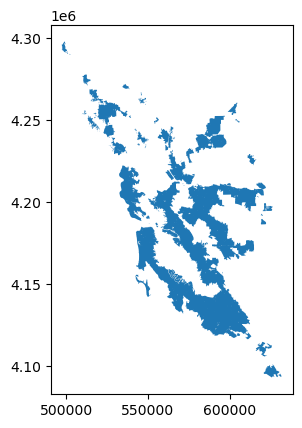

In [13]:
print(f"Creating Footprint for dataset: {ugb['name']}")
print(f"Using: {data_key(pca_geo)}")
ugb["footprint"] = create_footprint(ugb[data_key(pca_geo)], ugb['flag'])
ugb["footprint"].plot()
print("Creation of Footprint completed\n")

### Assign UGB Footprint to PCA Geographies

In [14]:
print(f"Dataset {ugb['name']}: Starting Assignment of Footprint")
print(f"Using: {data_key(pca_geo)}")
flag_name = ugb['flag']
ugb['assignment'] = assign_footprint(
    gdf_base=pca_geo[data_key(pca_geo)],
    gdf_over=ugb['footprint'],
    flag_name = flag_name
    )
print(f"Dataset {ugb['name']}: Assignment of Footprint complete\n")

Dataset EN4_Urban_Growth_Boundary: Starting Assignment of Footprint
Using: data
Creating Base GeoDataframe to Input GeoDataframe correspondence
Running Overlay process
Running Overlay process successful
Processing final fields: ['gdf_id', 'ugb']
took 0.5126 seconds
Dataset EN4_Urban_Growth_Boundary: Assignment of Footprint complete



In [15]:
ugb['assignment'].sample(3).T

,64,32,52
joinkey,SM15,CC2,NP2
source,PCA_Midpen_2024Refresh_SanMateoCounty.shp,CC2_Draft.shp,NP2_Draft.shp
fipco,06081,06013,06055
name,Windy Hill,Central Hercules and Waterfront District,Blue Oak Woodlands of the Lake District
lead,Midpeninsula Regional Open Space District,City of Hercules,Napa County Regional Park and Open Space District
amend_stat,nan,Draft,Draft
amend_lead,Local Lead,MTC,MTC
typenl,1,0,1
typeal,0,0,0
typeug,0,0,0


## Integrate Assignments of UGB to single Assignment file

In [16]:
## Assign UGB Footprint to PCA Geographies
## Assignment #1 should be run first
flag = ugb['flag']
cols = ['gdf_id', flag, f"{flag}_intersect_sq_m", f"{flag}_share_pct"]
pca_geo['assignment'] = pd.merge(
            pca_geo['assignment'],
            ugb['assignment'][cols].fillna(0),
            on='gdf_id',
            how='left'
            )
print(f"Assignment of Footprint for {ugb['flag']} completed")

Assignment of Footprint for ugb completed


### Check samples from Integrated Assignments table

In [17]:
pca_geo['assignment'].sample(3).T

,54,39,12
joinkey,NP4,MR20,AL34
source,NP4_Draft.shp,MR20_Draft2.shp,AL34_Draft.shp
fipco,06055,06041,06001
name,Palisades - Mount Saint Helena to Angwin,Multi-Jurisdictional: Southern Fairfax/Bald Hill,Oakland Recreational Trails
lead,Napa County Regional Park and Open Space District,"Fairfax, San Anselmo, Ross",City of Oakland
amend_stat,Draft,Draft,Draft
amend_lead,MTC,MTC,MTC
typenl,1,0,0
typeal,0,0,0
typeug,0,0,0


## Export Integrated Assignments #1 and #2 as Table

In [18]:
col_order = ['gdf_id'] + [c for c in pca_geo['assignment'].columns if c != 'gdf_id']
pca_geo['assignment'][col_order].fillna(0).to_csv('_data/evaluation_assignments/pca_type_assignment.csv', index=False)

## Flag #3 PCA to PCA

In [19]:
# Perform the overlay matrix operation
pca_geo['matrix'] = overlay_surface_percentage_matrix(pca_geo['data'], id_column='gdf_id', how='intersection')


Processing feature 1 of 110
Processing feature 2 of 110
Processing feature 3 of 110
Processing feature 4 of 110
Processing feature 5 of 110
Processing feature 6 of 110
Processing feature 7 of 110
Processing feature 8 of 110
Processing feature 9 of 110
Processing feature 10 of 110
Processing feature 11 of 110
Processing feature 12 of 110
Processing feature 13 of 110
Processing feature 14 of 110
Processing feature 15 of 110
Processing feature 16 of 110
Processing feature 17 of 110
Processing feature 18 of 110
Processing feature 19 of 110
Processing feature 20 of 110
Processing feature 21 of 110
Processing feature 22 of 110
Processing feature 23 of 110
Processing feature 24 of 110
Processing feature 25 of 110
Processing feature 26 of 110
Processing feature 27 of 110
Processing feature 28 of 110
Processing feature 29 of 110
Processing feature 30 of 110
Processing feature 31 of 110
Processing feature 32 of 110
Processing feature 33 of 110
Processing feature 34 of 110
Processing feature 35 o

/Users/LElias/opt/anaconda3/envs/dvutils/lib/python3.11/site-packages/geopandas/geodataframe.py:1813: FutureWarning: `unary_union` returned None due to all-None GeoSeries. In future, `unary_union` will return 'GEOMETRYCOLLECTION EMPTY' instead.
  merged_geom = block.unary_union


Processing feature 87 of 110
Processing feature 88 of 110
Processing feature 89 of 110
Processing feature 90 of 110
Processing feature 91 of 110
Processing feature 92 of 110
Processing feature 93 of 110
Processing feature 94 of 110
Processing feature 95 of 110


/Users/LElias/opt/anaconda3/envs/dvutils/lib/python3.11/site-packages/geopandas/geodataframe.py:1813: FutureWarning: `unary_union` returned None due to all-None GeoSeries. In future, `unary_union` will return 'GEOMETRYCOLLECTION EMPTY' instead.
  merged_geom = block.unary_union


Processing feature 96 of 110
Processing feature 97 of 110
Processing feature 98 of 110
Processing feature 99 of 110
Processing feature 100 of 110
Processing feature 101 of 110
Processing feature 102 of 110
Processing feature 103 of 110
Processing feature 104 of 110
Processing feature 105 of 110
Processing feature 106 of 110
Processing feature 107 of 110
Processing feature 108 of 110
Processing feature 109 of 110
Processing feature 110 of 110


### Export PCA to PCA Overlay Matrix

In [20]:
pca_geo['matrix'].fillna(0).to_csv('_data/evaluation_assignments/pca_matrix.csv', index=True)